In [1]:
import random

import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZGate
from qiskit.converters import circuit_to_dag

from dpqa_simple import DPQASimple, split_circuit

In [2]:
def random_circuit(N: int, depth: int, max_gate_size: int = 2) -> QuantumCircuit:
    qc = QuantumCircuit(N)
    ckz = [ZGate().control(n_controls) for n_controls in range(1, max_gate_size)]

    while qc.depth() < depth:
        n_controls = random.randint(1, max_gate_size - 1)
        qubits = random.sample(range(N), n_controls + 1)
        qc.append(ckz[n_controls - 1], qubits)

    return qc

def count_transports(positions: np.ndarray) -> int:
    num_qubits, T, _ = positions.shape
    transports = [
        np.linalg.norm(positions[n, t + 1] - positions[n, t])
        for t in range(T - 1)
        for n in range(num_qubits)
    ]
    return sum(transport > 0.5 for transport in transports)

def circuit_to_stages(circ: QuantumCircuit, stage_size: int) -> list[list[tuple[int, ...]]]:
    """Split a circuit into stages of a given size."""
    dag = circuit_to_dag(circ)
    stages = []
    for layer in dag.layers():
        gates = [gate for gate in layer["graph"].op_nodes() if gate.op.num_qubits >= 2]
        gates_qubits = [
            tuple(map(lambda q: circ.find_bit(q).index, gate.qargs)) for gate in gates
        ]
        # split gates into stages
        split_gates = [
            gates_qubits[i : i + stage_size]
            for i in range(0, len(gates_qubits), stage_size)
        ]
        stages += split_gates

    return stages

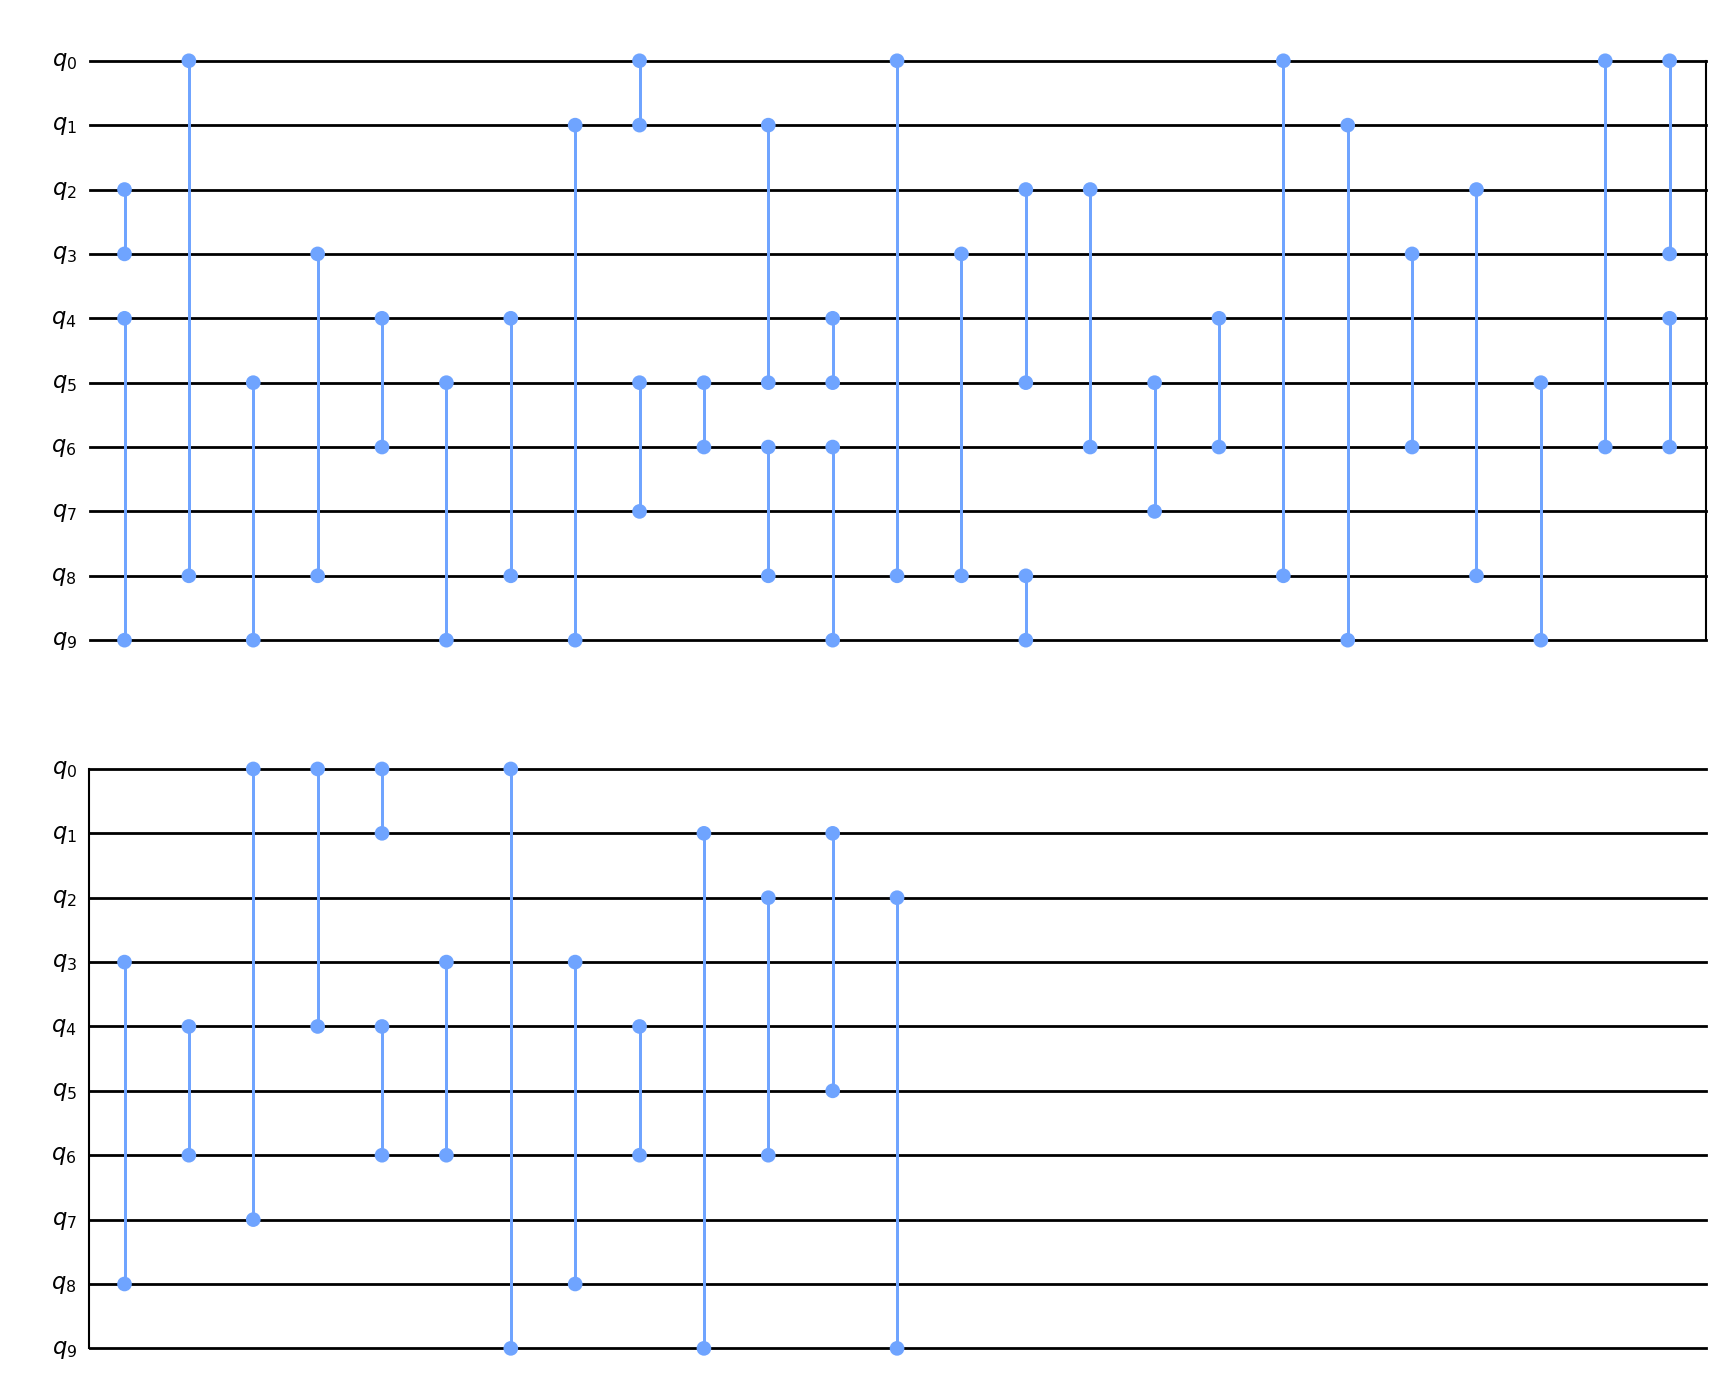

In [3]:
circ = random_circuit(10, 20)
circ.draw("mpl")

In [4]:
windows = split_circuit(circ, window_size=3)

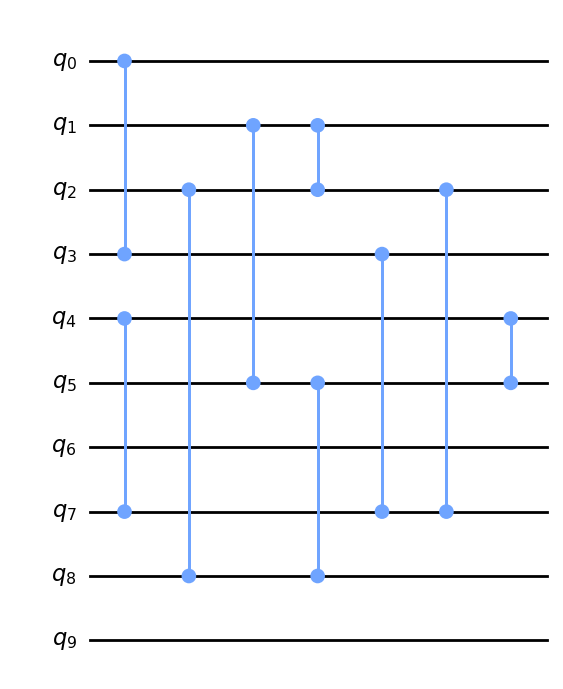

In [5]:
windows[0].draw("mpl")

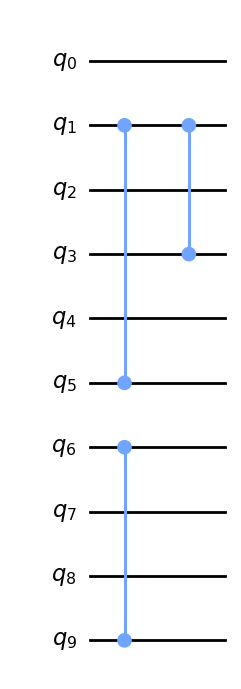

In [7]:
windows[2].draw("mpl")

In [4]:
dpqa = DPQASimple("Name", verbose=False,
                    minimize_distance=True)
results = dpqa.compile(circ,
                       optimal=False,
                       start = 2,
                    #    start=len(circuit_to_stages(circ, circ.num_qubits)),
                       window_size=3)


positions = [
    [(qubit["x"], qubit["y"]) for qubit in layer["qubits"]]
    for layer in results["layers"]
]
positions = np.transpose(np.array(positions), axes=(1, 0, 2))

optimal solving with 2 step
    no solution, step=2 too small
    found solution with 8 gates in 3 step
runtime 33.76622438430786
optimal solving with 2 step
    no solution, step=2 too small
    found solution with 6 gates in 3 step
runtime 3.998012065887451
optimal solving with 2 step
    no solution, step=2 too small
    found solution with 8 gates in 3 step
runtime 4.8121726512908936
optimal solving with 2 step
    no solution, step=2 too small
    found solution with 7 gates in 3 step
runtime 6.416475057601929
optimal solving with 2 step
    no solution, step=2 too small
    found solution with 6 gates in 3 step
runtime 3.4665143489837646
optimal solving with 2 step
    no solution, step=2 too small
    found solution with 7 gates in 3 step
runtime 5.3703155517578125
optimal solving with 2 step
    found solution with 3 gates in 2 step
runtime 1.7972254753112793


In [9]:
# Non minimize distance, optimal
count_transports(positions), results['duration']

(25, '1.6334526538848877')

In [9]:
# Window size 5
count_transports(positions), results['duration']

(28, '7.522837400436401')

In [11]:
# Window size 8
count_transports(positions), results['duration']

(25, '8.334828615188599')